# Collaboration and Competition

---

Resolution of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). For the detailed implementation see `Report.pdf` file.

**Necessary packages:**
- [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md)
- [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [1]:
from unityagents import UnityEnvironment
import numpy as np

try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe") # Change file_name if necessary
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Enviroment Details

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

# Project Resolution

The algorithms developed for this project are located in the following files:
- `utils.py`: Implementation of Config, OUNoise, Replay Memory.
- `nn.py`: Implementation of Actor-Critic Networks.
- `agent.py`: Implementation of the DDPG and PPO Agents.


In [2]:
from utils import Config
from agent import DDPG_Agent, MADDPG

Running on: cuda:0


#### Auxiliary Functions

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
# plot the scores

def plot_scores(scores, rolling_window=100, title=''):
    """Plot Agent Traininig Scores per Episode.
    
    Params
    ======
        scores (list): Scores over each episode.
        rolling_window (int): Rolling mean window length.
        title (string): Chart title.
    """
    fig = plt.figure(dpi=127)
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    plt.title(title)
    return rolling_mean

def plot_pkl_score(save_name, rolling_window=100, title=''):
    """Plot Saved Scores.
    
    Params
    ======
        save_name (string): Scores file name sufix.
        rolling_window (int): Rolling mean window length.
        title (string): Chart title.
    """
    
    with open(f'scores_{save_name}.pkl', 'rb') as handle:
        scores = pickle.load(handle)
        
        plot_scores(scores, rolling_window, title)

#### Training Function

In [4]:
import datetime
import time
import pickle
from collections import deque

class Trainer():
    
    TARGET_SCORE = 0.5
    def __init__(self, env, brain_name, agent, n_agents=1):
        self.agent = agent
        self.n_agents = n_agents
        self.scores_deque = deque(maxlen=100)     # last 100 scores
        self.scores_ep = []                       # list containing scores from each episode
        self.env = env
        self.brain_name = brain_name
        self.max_score = 0                        # initialize agent max score 

    def verbose(self, i_episode, avg_score, max_score, noise, exec_time, fix=True):
        if fix:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.3f} ' + \
                    f'Max Score: {max_score:.3f} ' + \
                    f'Noise: {noise:.3f} ' + \
                    f'exec.time: {exec_time}', end="")
        else:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.3f} ' + \
                    f'Max Score: {max_score:.3f} ' + \
                    f'Noise: {noise:.3f} ' + \
                    f'exec.time: {exec_time}')
    
    def train(self, n_episodes=1000, max_t=500, print_every=100, verbose=True, save=True, 
              save_name='', stop=False):
        
        start_time = time.time()                   # register start time
        num_agents = self.n_agents
        max_score = -np.inf
        
        for i_episode in range(1, n_episodes+1):
            env_info = self.env.reset(train_mode=True)[brain_name]   # Init Enviroment
            states = env_info.vector_observations                    # Get Initial State
            scores = np.zeros(self.n_agents)                            # array with episode scores
            self.agent.reset()                                       # Reset Noise
            
            for t in range(max_t):
                actions = self.agent.act(states)
                env_info = self.env.step(actions)[self.brain_name]
                next_state = env_info.vector_observations
                rewards = env_info.rewards
                done = env_info.local_done
                
                self.agent.step(states, actions, rewards, next_state, done)
                states = next_state
                scores += rewards
                
                if np.any(done):
                    break 
            
            ## Save scores
            self.scores_deque.append(np.mean(scores))
            self.scores_ep.append(np.mean(scores))
            
            ## Save max score
            if np.mean(scores) > max_score:
                max_score = np.mean(scores)

            exec_time = time.time() - start_time  # register execution time
            
            ## VERBOSE
            self.verbose(i_episode, np.mean(self.scores_deque), max_score, self.agent.get_noise()[0], 
                         str(datetime.timedelta(seconds=exec_time)), fix=True)

            if i_episode % print_every == 0 and verbose:
                self.verbose(i_episode, np.mean(self.scores_deque), max_score, self.agent.get_noise()[0], 
                         str(datetime.timedelta(seconds=exec_time)), fix=False)

            ## Check if eviroment is solved and save checkpoint
            if np.mean(self.scores_deque) >= self.TARGET_SCORE and len(self.scores_deque) == 100:
                if self.max_score == 0:
                    print(' <-- Objective Achived!')
                    print(f'- Average score of +{np.mean(self.scores_deque):.2f} over 100 consecutive episodes')

                    if stop:
                        print('- Trainining Finished -')
                        print(f'- Total training time:\t{str(datetime.timedelta(seconds=exec_time))}')
                        
                        if save:
                            self.agent.save_agents()
                            
                            with open(f'scores_{save_name}.pkl', 'wb') as handle:
                                pickle.dump(self.scores_ep, handle, protocol=pickle.HIGHEST_PROTOCOL)
                            
                        return self.scores_ep, i_episode

                if np.mean(self.scores_deque) >= self.max_score:
                    max_score = np.mean(self.scores_deque)

                    if save:
                        self.agent.save_agents()

        exec_time = time.time() - start_time                   # compute training time

        ## save training scores
        if save:
            with open(f'scores_{save_name}.pkl', 'wb') as handle:
                pickle.dump(self.scores_ep, handle, protocol=pickle.HIGHEST_PROTOCOL)


        print('- Trainining Finished -')
        print(f'\t-Total training time:\t{str(datetime.timedelta(seconds=exec_time))}')
        if self.max_score > 0:
            print(f'\t-Maximum average score of +{max_score} over 100 consecutive episodes')
        else:
            if stop:
                return self.scores_ep, 9999
            print('!!! Objective NOT achived !!!')
        return self.scores_ep
        


### Train MADDQN Agent

In [5]:
config = Config()

config.buffer_size = int(1e6)
config.batch_size = 512


config.gamma = 0.99
config.tau = 8e-3
config.lr_critic = 5e-4
config.lr_actor = 1e-4
config.l2_reg = 0
config.clip_grad_act = False
config.clip_grad_crit = 1

config.fc1_act = 64
config.fc2_act = 64
config.fc1_crit = 64
config.fc2_crit = 64
config.fc3_crit = 64
config.update_every = 4
config.update_times = 1
config.bn = True

config.noise_decay = 1
config.noise_decay_factor = 0.9998
config.min_noise = 0.01

In [6]:
with open('MADDDPG_config.pkl', 'wb') as handle:
    pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
agent = MADDPG(state_size, action_size, num_agents, random_seed=42, config=config)

In [9]:
trainer = Trainer(env, brain_name, agent, num_agents)

In [10]:
scores, _ = trainer.train(n_episodes=10000, max_t=1000, print_every=100, verbose=True, save=True, stop=True,
                          save_name='MADDDPG_')

Episode 100	Average Score: -0.000 Max Score: 0.095 Noise: 0.726 exec.time: 0:00:23.689709
Episode 200	Average Score: -0.003 Max Score: 0.095 Noise: 0.538 exec.time: 0:00:53.529248
Episode 300	Average Score: 0.001 Max Score: 0.145 Noise: 0.386 exec.time: 0:01:22.9005436
Episode 400	Average Score: 0.007 Max Score: 0.145 Noise: 0.263 exec.time: 0:01:55.881538
Episode 500	Average Score: 0.001 Max Score: 0.145 Noise: 0.190 exec.time: 0:02:23.974537
Episode 600	Average Score: 0.005 Max Score: 0.145 Noise: 0.133 exec.time: 0:02:54.7231473
Episode 700	Average Score: 0.032 Max Score: 0.145 Noise: 0.076 exec.time: 0:03:44.064096
Episode 800	Average Score: 0.049 Max Score: 0.195 Noise: 0.038 exec.time: 0:04:58.811554
Episode 900	Average Score: 0.092 Max Score: 0.595 Noise: 0.014 exec.time: 0:06:39.625961
Episode 1000	Average Score: 0.104 Max Score: 1.095 Noise: 0.010 exec.time: 0:08:18.666044
Episode 1100	Average Score: 0.066 Max Score: 1.095 Noise: 0.010 exec.time: 0:09:33.309623
Episode 1200	Av

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
1824    0.4526
1825    0.4531
1826    0.4696
1827    0.4851
1828    0.5031
Length: 1829, dtype: float64

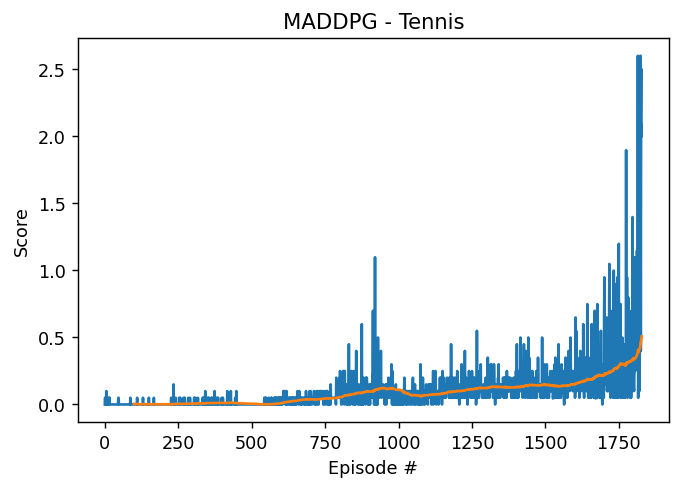

In [11]:
plot_scores(scores, rolling_window=100, title='MADDPG - Tennis')

### View Trained Agent in Action

In [5]:
with open('MADDDPG_config.pkl', 'rb') as handle:
    config = pickle.load(handle)

agent = MADDPG(state_size, action_size, num_agents, random_seed=0, config=config)

agent.load_agents()
                                   
for i in range(1):
    env_info = env.reset(train_mode=False)[brain_name]   # Init Enviroment
    states = env_info.vector_observations                    # Get Initial State
    scores = np.zeros(num_agents)                            # array with episode scores

    agent.reset()                                       # Reset Noise
    for t in range(500):
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        next_state = env_info.vector_observations
        rewards = env_info.rewards
        done = env_info.local_done
        states = next_state
        scores += rewards
#                 print(done)
        if np.any(done):
            break       
    print(f'Turn {i} Mean Score: {np.mean(scores)}')

Turn 0 Mean Score: 1.3000000193715096


# Trained Agent in Action

![SegmentLocal](imgs/MADDPG.gif "MADDPG")